In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
import matplotlib.pyplot as plt

learn = tf.contrib.learn
HIDDEN_SIZE = 30
NUM_LAYERS = 2
BATCH_SIZE = 32


def show_line(x,title):
    fig = plt.figure()
    plt.plot(x)
    plt.title(title)
    plt.show()


def show_lines(true, pred, title):
    fig = plt.figure()
    plt.plot(true)
    plt.plot(pred)
    plt.legend(['real', 'pred'])
    plt.title(title)
    plt.show()


def get_data(file_name):
    data = pd.read_excel('data/' + file_name, index_col=0).head(train_size + test_size + 1).values.astype(np.float32)
    if reverse_order:
        data = data[-1::-1].copy()
    colMin, colMax = data.min(axis=0), data.max(axis=0)
    rtef = []
    if use_random_time_effective_function:
        brown, beta = 0, 1
        for i in range(1, len(data) + 1):
            brown += np.random.rand()
            rtef.append(np.exp(-np.exp(-i / 300 + 1) + np.std(data[:i + 1, 0]) * (np.random.rand() - 0.5) / 100) / beta)
        rtef = np.array(rtef, dtype=np.float32)
        show_line(rtef,'random_effective function')
        data = (data - colMin) / (colMax - colMin)
        data = np.concatenate([data, rtef.reshape([-1, 1])], axis=1)
        return data.reshape([data.shape[0], 1, data.shape[1]]), colMax, colMin
    else:
        data = (data - colMin) / (colMax - colMin)
        return data.reshape([data.shape[0], 1, data.shape[1]]), colMax, colMin


def lstm_model_with_rt(X, y):
    rtef = X[:, :, -1]
    rtef = tf.reshape(rtef, [-1])
    X = X[:, :, :-1]
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE, state_is_tuple=True)
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell] * NUM_LAYERS)

    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = tf.reshape(output, [-1, HIDDEN_SIZE])

    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构。
    predictions = tf.contrib.layers.fully_connected(output, 1, None)

    # 将predictions和labels调整统一的shape
    labels = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])

    loss = tf.reduce_mean((predictions - labels) ** 2 * rtef)

    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(),
        optimizer="Adagrad", learning_rate=learning_rate)
    return predictions, loss, train_op


def lstm_model(X, y):
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE, state_is_tuple=True)
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell] * NUM_LAYERS)

    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = tf.reshape(output, [-1, HIDDEN_SIZE])

    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构。
    predictions = tf.contrib.layers.fully_connected(output, 1, None)

    # 将predictions和labels调整统一的shape
    labels = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])

    loss = tf.losses.mean_squared_error(predictions, labels)

    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(),
        optimizer="Adagrad", learning_rate=learning_rate)
    return predictions, loss, train_op


def run_Main(ci, use_random_time_effective_function):
    data, colMax, colMin = get_data(file_name=file_name + '.xlsx')

    # global rtef
    ci -= 1

    train_X, test_X = data[:train_size, :, :], data[train_size:train_size + test_size, :, :]
    train_y, test_y = data[1:train_size + 1, :, ci], data[1 + train_size:train_size + test_size + 1, :, ci]

    # 封装之前定义的lstm。
    if use_random_time_effective_function:
        regressor = SKCompat(learn.Estimator(model_fn=lstm_model_with_rt, model_dir="Models/models2"))
    else:
        regressor = SKCompat(learn.Estimator(model_fn=lstm_model, model_dir="Models/models1"))

    # 拟合数据。
    regressor.fit(train_X, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

    # 逆正规化
    train_y = train_y.reshape(-1) * (colMax[ci] - colMin[ci]) + colMin[ci]
    test_y = test_y.reshape(-1) * (colMax[ci] - colMin[ci]) + colMin[ci]

    # 计算预测值。
    _pred_train = regressor.predict(train_X)
    pred_train = colMin[ci] + _pred_train * (colMax[ci] - colMin[ci])
    print("\n**********************************\nTrain RMSE is : {:>.4f}".format(np.sqrt(np.mean((pred_train - train_y) ** 2))))

    _pred_test = regressor.predict(test_X)
    pred_test = colMin[ci] + _pred_test * (colMax[ci] - colMin[ci])
    print("Test RMSE is: {:>.4f}".format(np.sqrt(np.mean((pred_test - test_y) ** 2))))

    if offset_shift:
        y_all = data[:train_size + test_size, 0, 0] * (colMax[ci] - colMin[ci]) + colMin[ci]
    else:
        y_all = np.concatenate([train_y, test_y])
    pred_all = np.concatenate([pred_train, pred_test])
    print("All RMSE is: {:>.4f}\n**********************************\n".format(np.sqrt(np.mean((pred_all - y_all) ** 2))))

    # 画真实值与预测值图
    show_lines(y_all, pred_all, 'result of all data')
    show_lines(test_y, pred_test, 'result of test set')

    # 保存结果
    result = pd.DataFrame([y_all, pred_all], index=['real', 'pred']).T
    result_name='result/' + file_name + '_result.xlsx'
    if use_random_time_effective_function:
        result_name='result/ST-' + file_name + '_result.xlsx'
    result.to_excel(result_name, index=None)

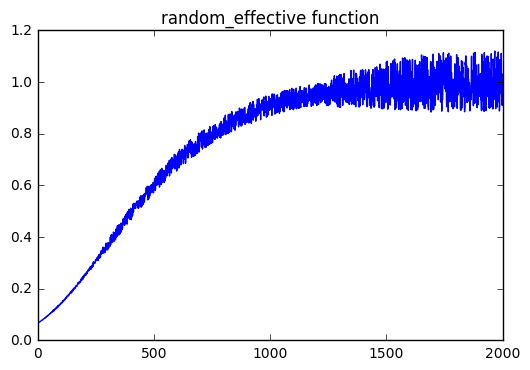

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_task_type': None, '_master': '', '_save_summary_steps': 100, '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001A26EC02588>, '_tf_random_seed': None, '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_environment': 'local', '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 15001 into Models/models2\model.ckpt.
INFO:tensorflow:loss = 0.000187565, step = 15001
INFO:tensorflow:global_step/sec: 256.02
INFO:tensorflow:loss = 0.000147551, step = 15101
INFO:tensorflow:global_step/sec: 304.783
INFO:tensorflow:loss = 0.00017285, step = 15201
INFO:tensorflow:global_step/sec: 288.748
INFO:tensorflow:loss = 0.000123971, step = 1

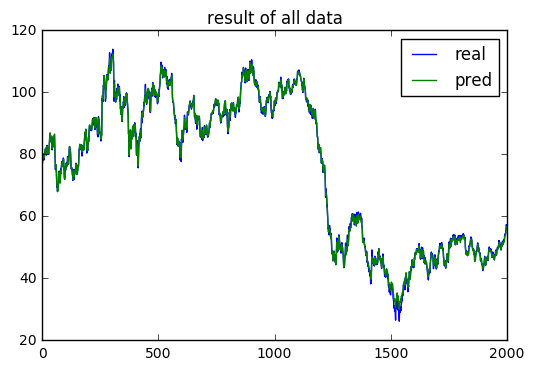

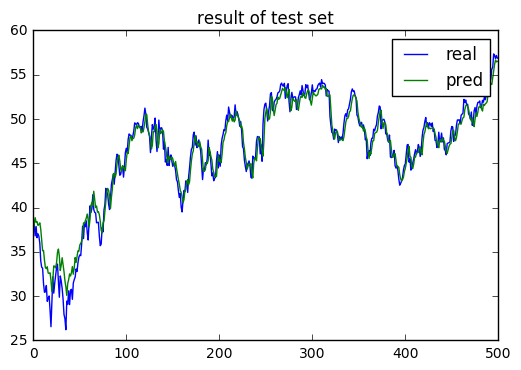

In [10]:
# 以下几个参数适当修改：
learning_rate = 0.05
TRAINING_STEPS = 3000  # 训练次数
train_size = 1500  # 训练集size
test_size = 500  # 测试集size
ci = 1  # 要预测的收盘价在四列数据中的第几列
file_name = 'WTI'  # 文件名（区分大小写，需是.xlsx格式）
reverse_order = True  # 是否将原数据逆序，不需要的话改为 False
offset_shift = True  # 是否将结果迁移一天（为True时会让误差更小）
use_random_time_effective_function = True  # 是否加入时效函数

# 运行
run_Main(ci, use_random_time_effective_function)